<a href="https://colab.research.google.com/github/Eugene31415/Pet-Projects/blob/main/Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import resize

import os

images = []
lesions = []

! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
get_ipython().system_raw("unrar x PH2Dataset.rar")
root = 'PH2Dataset'

# Fill image and mask lists
# for root, dirs, files in os.walk('../input/dataset/PH2 Dataset images'):
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
        
# Resize pictures
size = (224, 224)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

# Create numpy arrays out from lists
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images and {len(Y)} lesions')

--2020-12-16 14:23:33--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-16 14:23:34--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b6ce5b8e599ef4cd6668fc88d.dl.dropboxusercontent.com/cd/0/inline/BFKn9R5lm4stknkmJj3veoNmg69FSoVeXhMYWGcBXEgxj-YFFPtPT3vET6IuOABsMaWh0BFLJrloZjzqi2O1aLktxlAhNwU4uc812XEJ9VanVA/file# [following]
--2020-12-16 14:23:34--  https://uc2b6ce5b8e599ef4cd6668fc88d.dl.dropboxusercontent.com/cd/0/inline/BFKn9R5lm4stknkmJj3veoNmg69FSoVeXhMYWGcBXEgxj-YFFPtPT3vET6IuOABsMaWh0BFLJrloZjzqi2O1aLktxlAhNwU4uc812XEJ9VanVA/file
Resolving 

In [ ]:
ix = np.random.choice(len(X), len(X), False) # Изи, выбирает из массива подмассив опр длины
tr, val, ts = np.split(ix, [100,150]) # делит массив от нуля до 100, от 100 до 150 и от 150 до 200

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Даталоудеры без аугментации

In [ ]:
from torch.utils.data import DataLoader, Dataset
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), # при этом положение других осей относительно друг друга в нем не изменено.
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
# from torchsummary import summary
from sklearn.metrics import roc_auc_score
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output


from matplotlib import rcParams
rcParams['figure.figsize'] = (20,7)

Класс обертка для аугментации

In [ ]:
class Leasures (Dataset):
    def __init__(self, mode):
        super().__init__()
        self.mode = mode
        if self.mode == 'train':
            self.idxs = tr
        elif self.mode == 'val':
            self.idxs = val
        elif self.mode == 'test':
            self.idxs = ts

    def __len__(self):
        return len(self.idxs) 

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0), 
            transforms.ToTensor()
        ])
        x = torch.Tensor(np.rollaxis(X[self.idxs][index],2,0))
        y = torch.Tensor(Y[self.idxs][index, np.newaxis])

        mix = torch.cat((x,y),0)
        new_mix = transform(mix)

        new_x = new_mix[:3,...]
        new_y = new_mix[-1,...]

        return new_x, new_y[np.newaxis]
        

Даталоудеры с аугментацией

In [ ]:
train_dataset = Leasures('train')
val_dataset = Leasures('val')
test_dataset = Leasures('test')

train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)

# **Segnet**

In [ ]:
# Edited
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2)

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottle = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            # nn.BatchNorm2d(512),
            # nn.ReLU()
        )

        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )


        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, padding=1, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, padding=1, kernel_size=(3, 3)),
        )


    def forward(self, x):
        # encoder
        e0, indices1 = self.pool(self.enc_conv0(x)) # outpoot - 128
        e1, indices2 = self.pool(self.enc_conv1(e0)) # outpoot - 64
        e2, indices3 = self.pool(self.enc_conv2(e1)) # outpoot - 32
        e3, indices4 = self.pool(self.enc_conv3(e2)) # outpoot - 16
       
        b1 = self.bottle(e3)

        # decoder
        d0 = self.dec_conv0(self.unpool(b1, indices4))  # input - 16
        d1 = self.dec_conv1(self.unpool(d0, indices3)) # input - 32
        d2 = self.dec_conv2(self.unpool(d1, indices2)) # input - 64
        d3 = self.dec_conv3(self.unpool(d2, indices1))  # no activation

        return d3

# Unet

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        #=======================================================================
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #--------
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #--------
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #--------
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #=======================================================================
        self.bottle = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #--------
        self.de_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #--------
        self.de_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #--------
        self.de_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #--------
        self.de_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=3,padding=1)
        )
        #=======================================================================
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        #--------
        self.unpool1 = nn.UpsamplingBilinear2d(28)
        #--------
        self.unpool2 = nn.UpsamplingBilinear2d(56)
        #--------
        self.unpool3 = nn.UpsamplingBilinear2d(112)
        #--------
        self.unpool4 = nn.UpsamplingBilinear2d(224)
        #=======================================================================

    def forward(self, x):

        # encoder
        step1 = self.conv1(x) # <------------- 224
        step2 = self.pool(step1) # 64*112*112
        step3 = self.conv2(step2) # <<------------- 112
        step4 = self.pool(step3) # 128*56*56
        step5 = self.conv3(step4) # <<------------- 56
        step6 = self.pool(step5) # 256*28*28
        step7 = self.conv4(step6) # <<------------- 28
        step8 = self.pool(step7) # 512*14*14
        

        # bottleneck
        b = self.bottle(step8) # 1024*14*14
        
        # decoder
        d0 = self.de_conv1(torch.cat((step7, self.unpool1(b)), dim=1))
        d1 = self.de_conv2(torch.cat((step5, self.unpool2(d0)), dim=1))
        d2 = self.de_conv3(torch.cat((step3, self.unpool3(d1)), dim=1))
        d3 = self.de_conv4(torch.cat((step1, self.unpool4(d2)), dim=1))

        return d3

# Unet 2

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        #=======================================================================
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #--------
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #--------
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #--------
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #=======================================================================
        self.bottle = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        #--------
        self.de_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        #--------
        self.de_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        #--------
        self.de_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #--------
        self.de_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=3,padding=1)
        )
        #=======================================================================
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #--------
        self.unpool1 = nn.Upsample(28)
        #--------
        self.unpool2 = nn.Upsample(56)
        #--------
        self.unpool3 = nn.Upsample(112)
        #--------
        self.unpool4 = nn.Upsample(224)
        #=======================================================================

    def forward(self, x):

        # encoder
        step1 = self.conv1(x) # <------------- 224
        step2 = self.pool(step1) # 64*112*112
        step3 = self.conv2(step2) # <<------------- 112
        step4 = self.pool(step3) # 128*56*56
        step5 = self.conv3(step4) # <<------------- 56
        step6 = self.pool(step5) # 256*28*28
        step7 = self.conv4(step6) # <<------------- 28
        step8 = self.pool(step7) # 512*14*14
        

        # bottleneck
        b = self.bottle(step8) # 1024*14*14
        
        # decoder
        d0 = self.de_conv1(torch.cat((step7, self.unpool1(b)), dim=1))
        d1 = self.de_conv2(torch.cat((step5, self.unpool2(d0)), dim=1))
        d2 = self.de_conv3(torch.cat((step3, self.unpool3(d1)), dim=1))
        d3 = self.de_conv4(torch.cat((step1, self.unpool4(d2)), dim=1))

        return d3

# Train

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val,lr_step = None):
    X_val, Y_val = next(iter(data_val))
    loss_tr_history = []
    loss_val_history = []
    metric_tr_history = []
    metric_val_history = []

    if lr_step != None:
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=lr_step, gamma=0.1,verbose=True)
    else:
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.1,verbose=True)
        
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch,Y_pred) 
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss_tr += loss / len(data_tr)

        toc = time()
        loss_tr_history.append(avg_loss_tr)
        metric_tr_history.append(score_model(model, iou_pytorch, data_tr))

        avg_loss_val = 0
        model.eval()  # testing mode

        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu()
            for X_batch, Y_batch in data_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                opt.zero_grad()
                Y_pred = model(X_batch)
                avg_loss_val += loss_fn(Y_batch,Y_pred)

        loss_val_history.append(avg_loss_val)
        metric_val_history.append(score_model(model, iou_pytorch, data_val))

        scheduler.step()

        # Visualize tools
        clear_output(wait=True)
#         for k in range(5):
#             plt.subplot(3, 6, k+1)
#             plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
#             plt.title('Real')
#             plt.axis('off')

#             plt.subplot(3, 6, k+7)
#             plt.imshow((Y_hat[k,0]>0.5), cmap='gray')
#             plt.title('Output')
#             plt.axis('off')

#             plt.subplot(3, 6, k+13)
#             plt.imshow((Y_val[k,0]), cmap='gray')
#             plt.title('Mask')
#             plt.axis('off')
        plt.suptitle('%d / %d - loss: %f | IoU: %f ' % (epoch+1, epochs, avg_loss_val, score_model(model, iou_pytorch, data_val)))
#         plt.show()

        torch.cuda.empty_cache()

    return loss_tr_history, loss_val_history, metric_tr_history, metric_val_history


In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
            torch.cuda.empty_cache()

    return scores/len(data)
# score_model(model, iou_pytorch, data_val)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # удаляет оси с одним элементом (длинной 1) BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    # print((intersection + SMOOTH),(union + SMOOTH))
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

In [ ]:
def bce_loss(y_real, y_pred):
    ans = torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
    return ans

In [ ]:
def dice_loss(y_real, y_pred):  

    y_pred = torch.sigmoid(y_pred)

    num = 2 * (y_real * y_pred).mean((1,2,3))
    den = (y_real + y_pred).mean((1,2,3))
    
    res = (1 - (num/den)).mean()

    return res

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps, 1) # hint: torch.clamp
    BCE = bce_loss(y_real,y_pred)
    pt = torch.exp(BCE)
    loss = (1 - pt)**gamma *BCE
    return loss.mean()

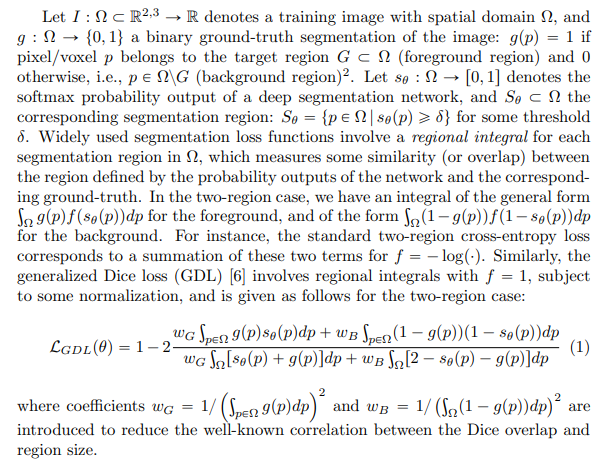

In [ ]:
def Bloss(label,pred):
    
    pred = torch.sigmoid(pred)

    Wg = 1 / (label.sum((2,3))**2)
    Wb = 1 / ((1 - label).sum((2,3))**2)

    first = (label*pred).sum((2,3))
    second = ((1 - label)*(1 - pred)).sum((2,3))
    third = (label + pred).sum((2,3))
    forth = (2 - label - pred).sum((2,3))

    loss = 1 - 2*(Wg*first + Wb*second)/(Wg*third + Wb*forth)

    return loss.mean()


Первым делом необходимо определить оптимальную Лосс функцию для каждой модели


# ОТЧЕТ

Ниже приведены тренировки каждой модели с 4мя функциями потерь для аугментированных картинок или дефолтных. Моя реализация кастомной функции потерь имеет название Boundary Loss, но по факту я реализовал GDS, то есть обобщенный дайс лосс.

В конце отчета приведено сравнение трех моделей со своими лучшими лосс функциями. Сравение происходит на тестовой выборке.

- Так же следует сделать тонкое замечание по поводу обучения поделей и перезагрузки блокнота. При перезагрузке блокнота происходит перераспределение индексов для train, valid и test выборок. Так что для наиболее точной оценки моделей необходимо обучать их во время одной сессии, то есть на одном и том же трейне.
- Финальное сравнение самих моделей проводилось на других тестовых данных и их обучение проводилось на других трейновых данных, нежели при сравнении лосс функций, но это ни на что не влияет.
- Также проводилась тренировка моделей на трейновом датасете размером в 150 картинок, когда на валидацию приходилось 50 картинок и на тест 0 картинок. В таком случае с аугментацией удавалось выбить скор 87 % на одном из UNet. К сожалению, данные тренировки не попали в отчет.


# Segnet without augmentation

In [ ]:
segnet1 = SegNet().to(device)
opt = optim.Adam(segnet1.parameters(), lr=1e-4)
a1,b1,c1,d1 = train(segnet1, opt, bce_loss, 100, data_tr, data_val,30)

segnet2 = SegNet().to(device)
opt = optim.Adam(segnet2.parameters(), lr=1e-4)
a2,b2,c2,d2 = train(segnet2, opt, dice_loss, 100, data_tr, data_val,30)

segnet3 = SegNet().to(device)
opt = optim.Adam(segnet3.parameters(), lr=1e-4)
a3,b3,c3,d3 = train(segnet3, opt, focal_loss, 100, data_tr, data_val,30)

segnet4 = SegNet().to(device)
opt = optim.Adam(segnet4.parameters(), lr=1e-4)
a4,b4,c4,d4 = train(segnet4, opt, Bloss, 100, data_tr, data_val,30)


<Figure size 1440x504 with 0 Axes>

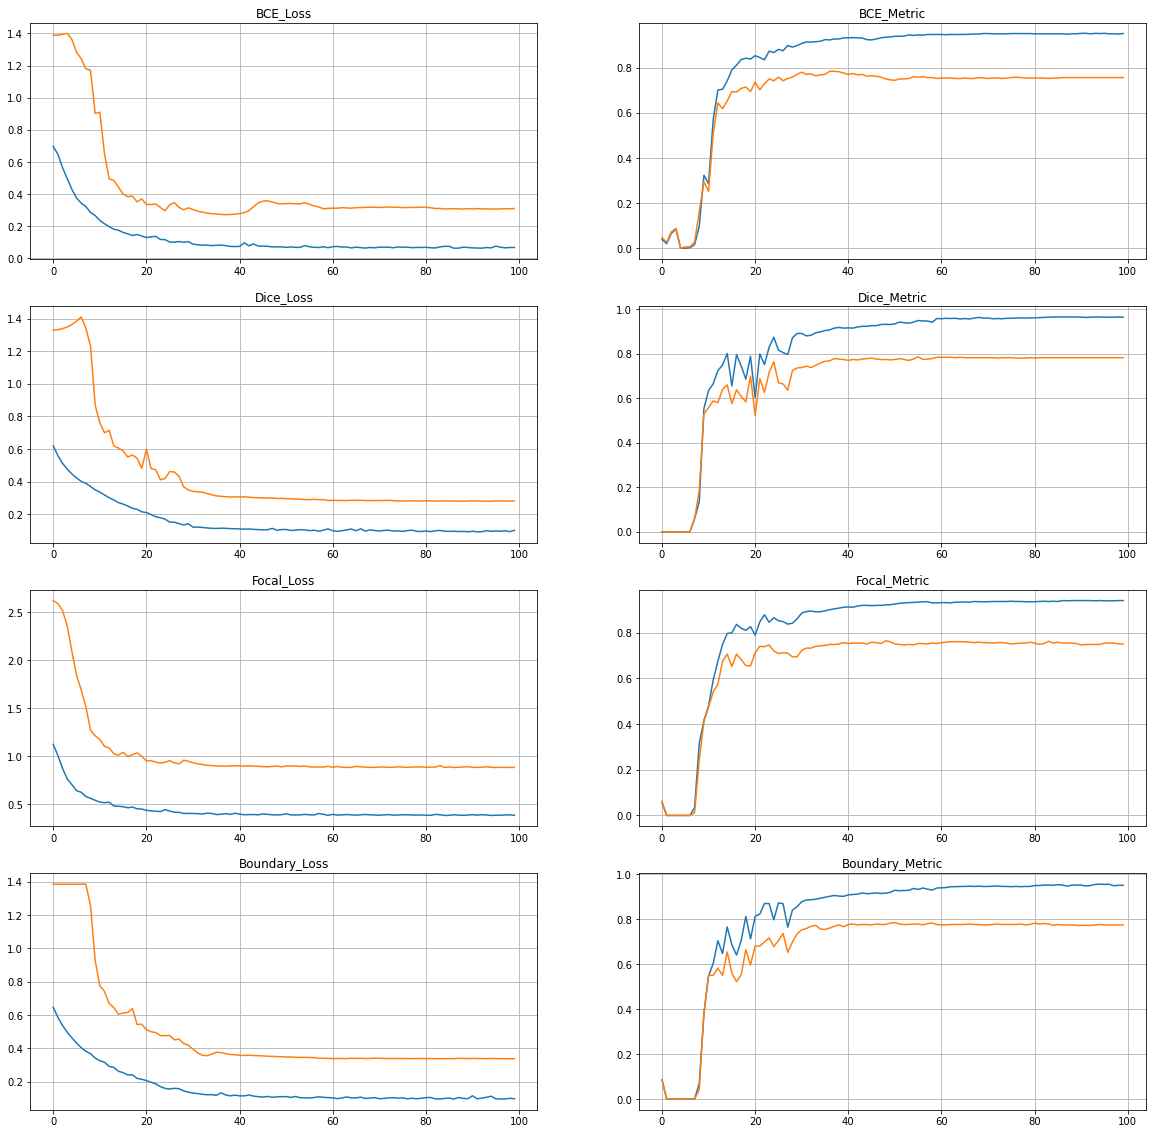

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a1)
ax[0].plot(b1)
ax[0].set_title('BCE_Loss')
ax[1].plot(c1)
ax[1].plot(d1)
ax[1].set_title('BCE_Metric')

ax[2].plot(a2)
ax[2].plot(b2)
ax[2].set_title('Dice_Loss')
ax[3].plot(c2)
ax[3].plot(d2)
ax[3].set_title('Dice_Metric')

ax[4].plot(a3)
ax[4].plot(b3)
ax[4].set_title('Focal_Loss')
ax[5].plot(c3)
ax[5].plot(d3)
ax[5].set_title('Focal_Metric')

ax[6].plot(a4)
ax[6].plot(b4)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c4)
ax[7].plot(d4)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(segnet1,iou_pytorch,data_val), \
score_model(segnet2,iou_pytorch,data_val), \
score_model(segnet3,iou_pytorch,data_val), \
score_model(segnet4,iou_pytorch,data_val)

(0.7560000121593475, 0.7819999754428864, 0.75, 0.7740000486373901)

# SegNet with augmentation

In [ ]:
segnet1_aug = SegNet().to(device)
opt = optim.Adam(segnet1_aug.parameters(), lr=1e-4)
a1_aug,b1_aug,c1_aug,d1_aug = train(segnet1_aug, opt, bce_loss, 100, train_dataloader, val_dataloader,30)

segnet2_aug = SegNet().to(device)
opt = optim.Adam(segnet2_aug.parameters(), lr=1e-4)
a2_aug,b2_aug,c2_aug,d2_aug = train(segnet2_aug, opt, dice_loss, 100, train_dataloader, val_dataloader,30)

segnet3_aug = SegNet().to(device)
opt = optim.Adam(segnet3_aug.parameters(), lr=1e-4)
a3_aug,b3_aug,c3_aug,d3_aug = train(segnet3_aug, opt, focal_loss, 100, train_dataloader, val_dataloader,30)

segnet4_aug = SegNet().to(device)
opt = optim.Adam(segnet4_aug.parameters(), lr=1e-4)
a4_aug,b4_aug,c4_aug,d4_aug = train(segnet4_aug, opt, Bloss, 100, train_dataloader, val_dataloader,30)


<Figure size 1440x504 with 0 Axes>

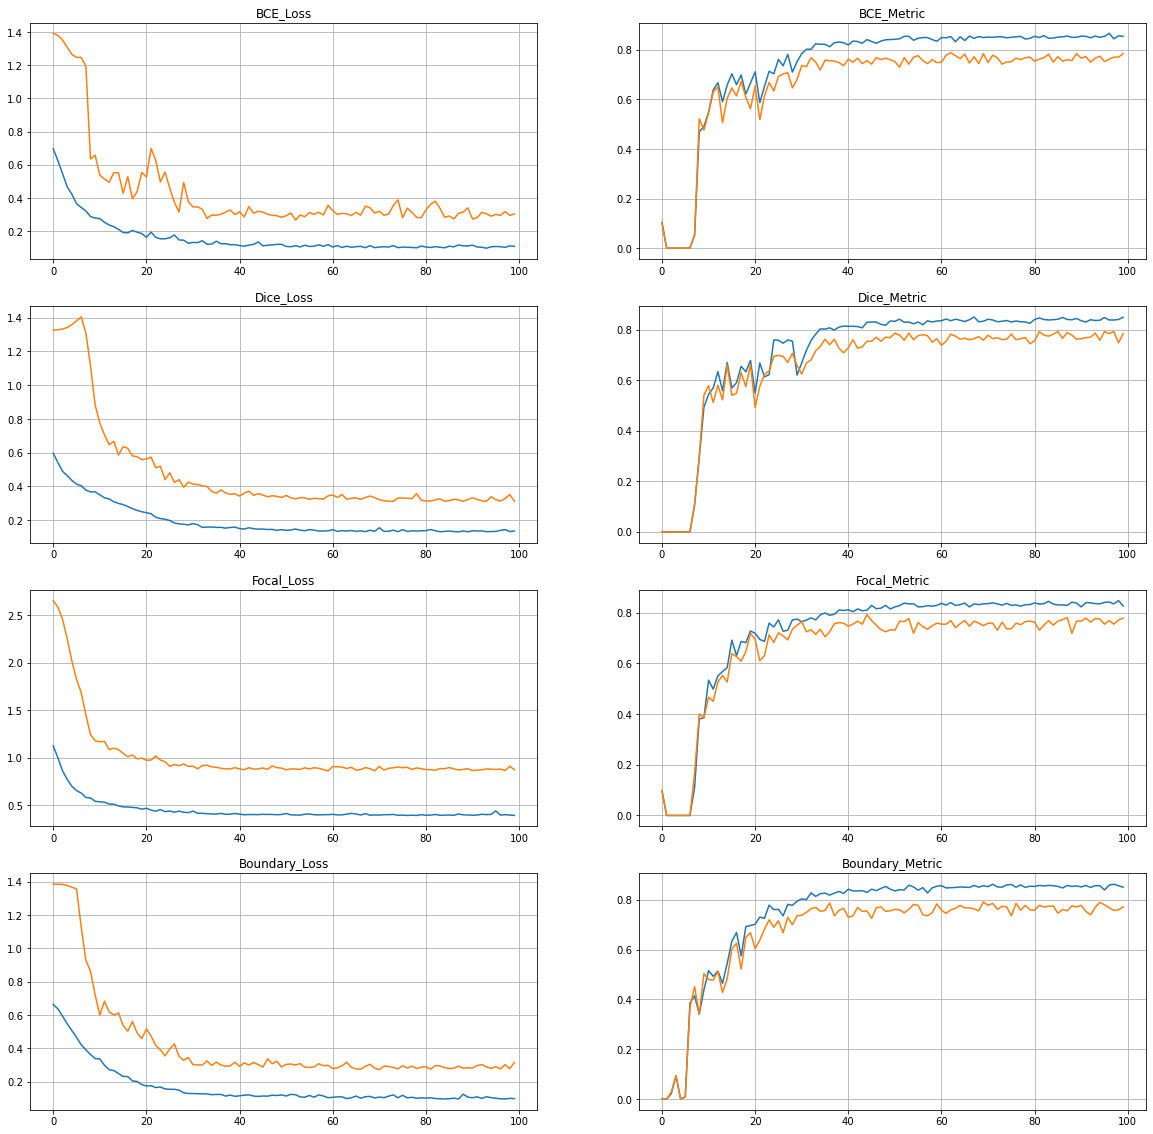

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a1_aug)
ax[0].plot(b1_aug)
ax[0].set_title('BCE_Loss')
ax[1].plot(c1_aug)
ax[1].plot(d1_aug)
ax[1].set_title('BCE_Metric')

ax[2].plot(a2_aug)
ax[2].plot(b2_aug)
ax[2].set_title('Dice_Loss')
ax[3].plot(c2_aug)
ax[3].plot(d2_aug)
ax[3].set_title('Dice_Metric')

ax[4].plot(a3_aug)
ax[4].plot(b3_aug)
ax[4].set_title('Focal_Loss')
ax[5].plot(c3_aug)
ax[5].plot(d3_aug)
ax[5].set_title('Focal_Metric')

ax[6].plot(a4_aug)
ax[6].plot(b4_aug)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c4_aug)
ax[7].plot(d4_aug)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(segnet1_aug,iou_pytorch,data_val), \
score_model(segnet2_aug,iou_pytorch,data_val), \
score_model(segnet3_aug,iou_pytorch,data_val), \
score_model(segnet4_aug,iou_pytorch,data_val)

(0.7919999659061432,
 0.7900000810623169,
 0.7840000092983246,
 0.7840000092983246)

In [ ]:
score_model(segnet1_aug,iou_pytorch,val_dataloader), \
score_model(segnet2_aug,iou_pytorch,val_dataloader), \
score_model(segnet3_aug,iou_pytorch,val_dataloader), \
score_model(segnet4_aug,iou_pytorch,val_dataloader)

(0.7560000121593475,
 0.7459999918937683,
 0.7480000555515289,
 0.7520000040531158)

# UNet_1 without augmentation

In [ ]:
unet11 = UNet().to(device)
opt = optim.Adam(unet11.parameters(), lr=1e-4)
a11,b11,c11,d11 = train(unet11, opt, bce_loss, 100, data_tr, data_val,30)

unet12 = UNet().to(device)
opt = optim.Adam(unet12.parameters(), lr=1e-4)
a12,b12,c12,d12 = train(unet12, opt, dice_loss, 100, data_tr, data_val,30)

unet13 = UNet().to(device)
opt = optim.Adam(unet13.parameters(), lr=1e-4)
a13,b13,c13,d13 = train(unet13, opt, focal_loss, 100, data_tr, data_val,30)

unet14 = UNet().to(device)
opt = optim.Adam(unet14.parameters(), lr=1e-4)
a14,b14,c14,d14 = train(unet14, opt, Bloss, 100, data_tr, data_val,30)

<Figure size 1440x504 with 0 Axes>

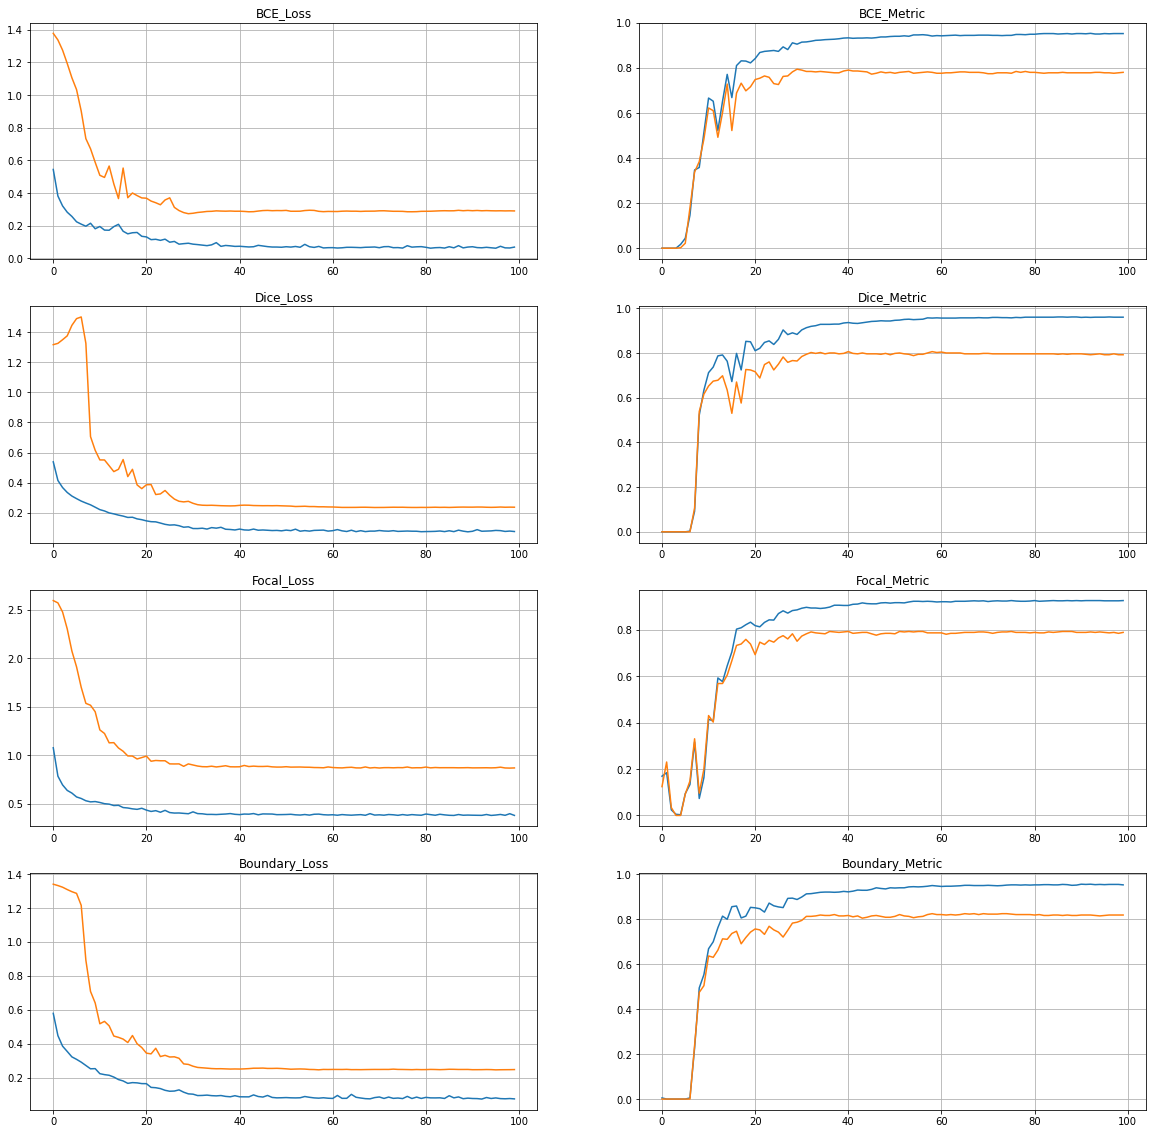

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a11)
ax[0].plot(b11)
ax[0].set_title('BCE_Loss')
ax[1].plot(c11)
ax[1].plot(d11)
ax[1].set_title('BCE_Metric')

ax[2].plot(a12)
ax[2].plot(b12)
ax[2].set_title('Dice_Loss')
ax[3].plot(c12)
ax[3].plot(d12)
ax[3].set_title('Dice_Metric')

ax[4].plot(a13)
ax[4].plot(b13)
ax[4].set_title('Focal_Loss')
ax[5].plot(c13)
ax[5].plot(d13)
ax[5].set_title('Focal_Metric')

ax[6].plot(a14)
ax[6].plot(b14)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c14)
ax[7].plot(d14)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(unet11,iou_pytorch,val_dataloader), \
score_model(unet12,iou_pytorch,val_dataloader), \
score_model(unet13,iou_pytorch,val_dataloader), \
score_model(unet14,iou_pytorch,val_dataloader)

(0.6539999842643738,
 0.6579999625682831,
 0.6859999895095825,
 0.6940000057220459)

In [ ]:
score_model(unet11,iou_pytorch,data_val), \
score_model(unet12,iou_pytorch,data_val), \
score_model(unet13,iou_pytorch,data_val), \
score_model(unet14,iou_pytorch,data_val)

(0.7799999713897705, 0.792000025510788, 0.7880000174045563, 0.817999929189682)

# UNet_1 with augmentation

In [ ]:
unet11_aug = UNet().to(device)
opt = optim.Adam(unet11_aug.parameters(), lr=1e-4)
a11_aug,b11_aug,c11_aug,d11_aug = train(unet11_aug, opt, bce_loss, 100, train_dataloader, val_dataloader,30)

unet12_aug = UNet().to(device)
opt = optim.Adam(unet12_aug.parameters(), lr=1e-4)
a12_aug,b12_aug,c12_aug,d12_aug = train(unet12_aug, opt, dice_loss, 100, train_dataloader, val_dataloader,30)

unet13_aug = UNet().to(device)
opt = optim.Adam(unet13_aug.parameters(), lr=1e-4)
a13_aug,b13_aug,c13_aug,d13_aug = train(unet13_aug, opt, focal_loss, 100, train_dataloader, val_dataloader,30)

unet14_aug = UNet().to(device)
opt = optim.Adam(unet14_aug.parameters(), lr=1e-4)
a14_aug,b14_aug,c14_aug,d14_aug = train(unet14_aug, opt, Bloss, 100, train_dataloader, val_dataloader,30)

<Figure size 1440x504 with 0 Axes>

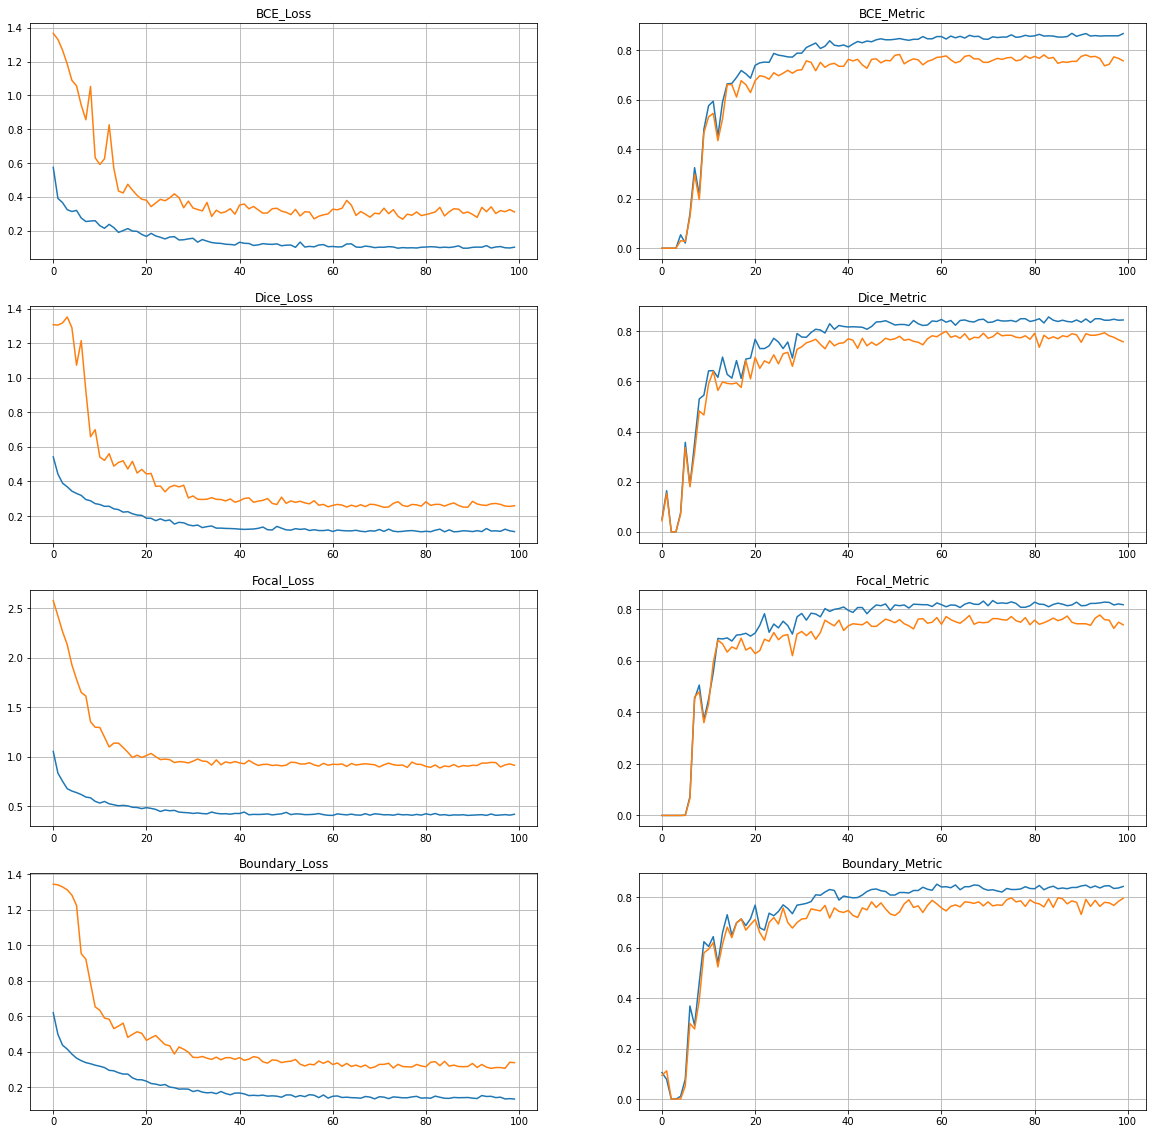

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a11_aug)
ax[0].plot(b11_aug)
ax[0].set_title('BCE_Loss')
ax[1].plot(c11_aug)
ax[1].plot(d11_aug)
ax[1].set_title('BCE_Metric')

ax[2].plot(a12_aug)
ax[2].plot(b12_aug)
ax[2].set_title('Dice_Loss')
ax[3].plot(c12_aug)
ax[3].plot(d12_aug)
ax[3].set_title('Dice_Metric')

ax[4].plot(a13_aug)
ax[4].plot(b13_aug)
ax[4].set_title('Focal_Loss')
ax[5].plot(c13_aug)
ax[5].plot(d13_aug)
ax[5].set_title('Focal_Metric')

ax[6].plot(a14_aug)
ax[6].plot(b14_aug)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c14_aug)
ax[7].plot(d14_aug)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(unet11_aug,iou_pytorch,val_dataloader), \
score_model(unet12_aug,iou_pytorch,val_dataloader), \
score_model(unet13_aug,iou_pytorch,val_dataloader), \
score_model(unet14_aug,iou_pytorch,val_dataloader)

(0.7620000243186951,
 0.7899999618530273,
 0.7639999985694885,
 0.7559999823570251)

In [ ]:
score_model(unet11_aug,iou_pytorch,data_val), \
score_model(unet12_aug,iou_pytorch,data_val), \
score_model(unet13_aug,iou_pytorch,data_val), \
score_model(unet14_aug,iou_pytorch,data_val)

(0.7520000040531158, 0.785999983549118, 0.7660000026226044, 0.8099999725818634)

# UNet_2 without augmentation

In [ ]:
unet21 = UNet2().to(device)
opt = optim.Adam(unet21.parameters(), lr=1e-4)
a21,b21,c21,d21 = train(unet21, opt, bce_loss, 100, data_tr, data_val,30)

unet22 = UNet2().to(device)
opt = optim.Adam(unet22.parameters(), lr=1e-4)
a22,b22,c22,d22 = train(unet22, opt, dice_loss, 100, data_tr, data_val,30)

unet23 = UNet2().to(device)
opt = optim.Adam(unet23.parameters(), lr=1e-4)
a23,b23,c23,d23 = train(unet23, opt, focal_loss, 100, data_tr, data_val,30)

unet24 = UNet2().to(device)
opt = optim.Adam(unet24.parameters(), lr=1e-4)
a24,b24,c24,d24 = train(unet24, opt, Bloss, 100, data_tr, data_val,30)

<Figure size 1440x504 with 0 Axes>

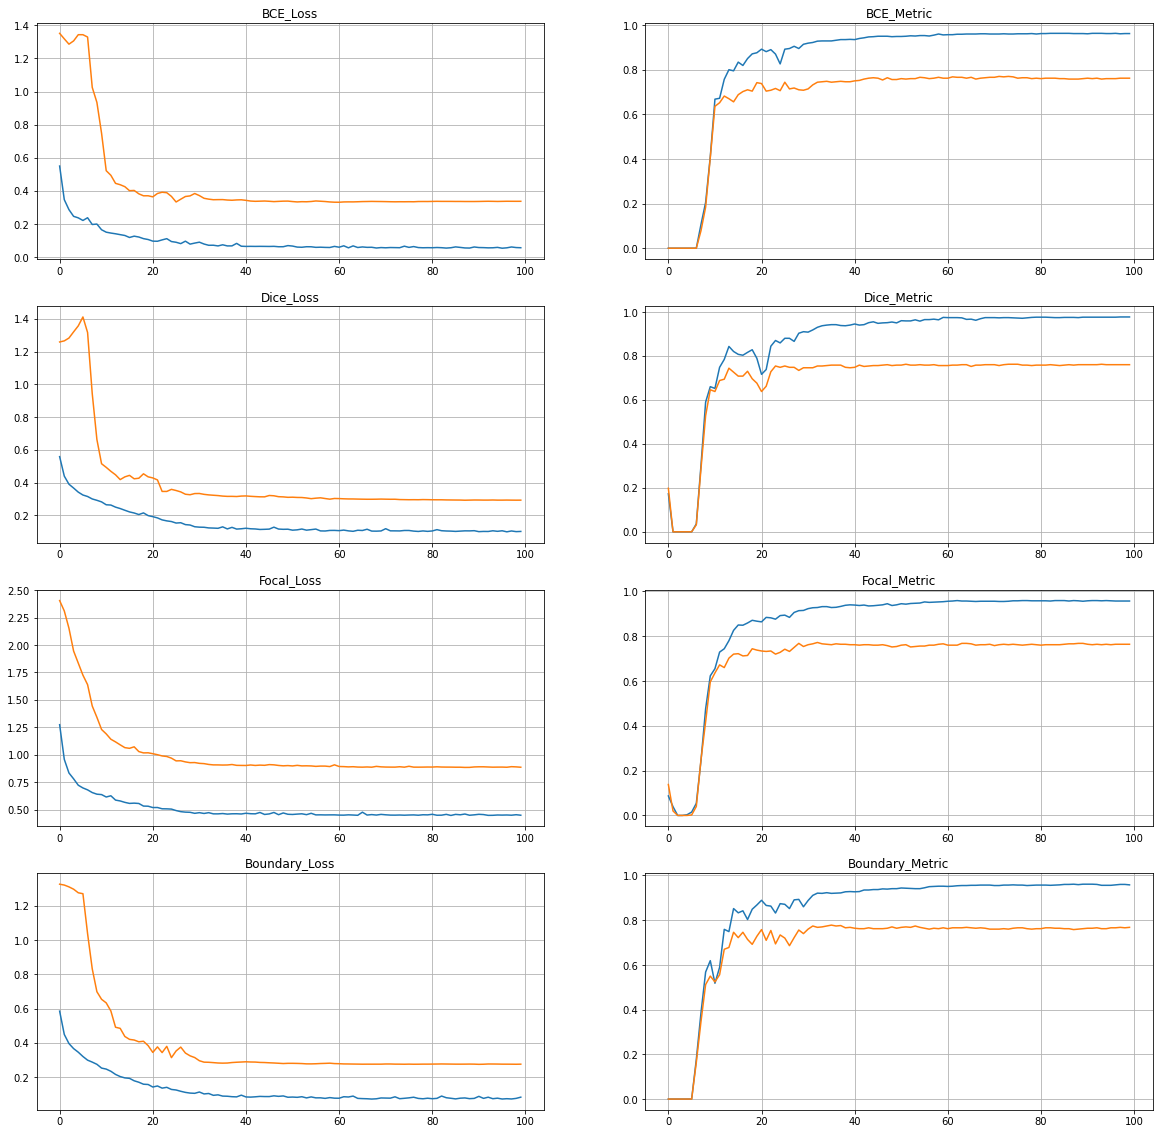

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a21)
ax[0].plot(b21)
ax[0].set_title('BCE_Loss')
ax[1].plot(c21)
ax[1].plot(d21)
ax[1].set_title('BCE_Metric')

ax[2].plot(a22)
ax[2].plot(b22)
ax[2].set_title('Dice_Loss')
ax[3].plot(c22)
ax[3].plot(d22)
ax[3].set_title('Dice_Metric')

ax[4].plot(a23)
ax[4].plot(b23)
ax[4].set_title('Focal_Loss')
ax[5].plot(c23)
ax[5].plot(d23)
ax[5].set_title('Focal_Metric')

ax[6].plot(a24)
ax[6].plot(b24)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c24)
ax[7].plot(d24)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(unet21,iou_pytorch,val_dataloader), \
score_model(unet22,iou_pytorch,val_dataloader), \
score_model(unet23,iou_pytorch,val_dataloader), \
score_model(unet24,iou_pytorch,val_dataloader)

(0.7020000219345093,
 0.6820000112056732,
 0.6680000126361847,
 0.7219999730587006)

In [ ]:
score_model(unet21,iou_pytorch,data_val), \
score_model(unet22,iou_pytorch,data_val), \
score_model(unet23,iou_pytorch,data_val), \
score_model(unet24,iou_pytorch,data_val)

(0.7620000243186951,
 0.7599999904632568,
 0.7639999985694885,
 0.7679999768733978)

# UNet_2 with augmentation

In [ ]:
unet21_aug = UNet2().to(device)
opt = optim.Adam(unet21_aug.parameters(), lr=1e-4)
a21_aug,b21_aug,c21_aug,d21_aug = train(unet21_aug, opt, bce_loss, 100, train_dataloader, val_dataloader,30)

unet22_aug = UNet2().to(device)
opt = optim.Adam(unet22_aug.parameters(), lr=1e-4)
a22_aug,b22_aug,c22_aug,d22_aug = train(unet22_aug, opt, dice_loss, 100, train_dataloader, val_dataloader,30)

unet23_aug = UNet2().to(device)
opt = optim.Adam(unet23_aug.parameters(), lr=1e-4)
a23_aug,b23_aug,c23_aug,d23_aug = train(unet23_aug, opt, focal_loss, 100, train_dataloader, val_dataloader,30)

unet24_aug = UNet2().to(device)
opt = optim.Adam(unet24_aug.parameters(), lr=1e-4)
a24_aug,b24_aug,c24_aug,d24_aug = train(unet24_aug, opt, Bloss, 100, train_dataloader, val_dataloader,30)

<Figure size 1440x504 with 0 Axes>

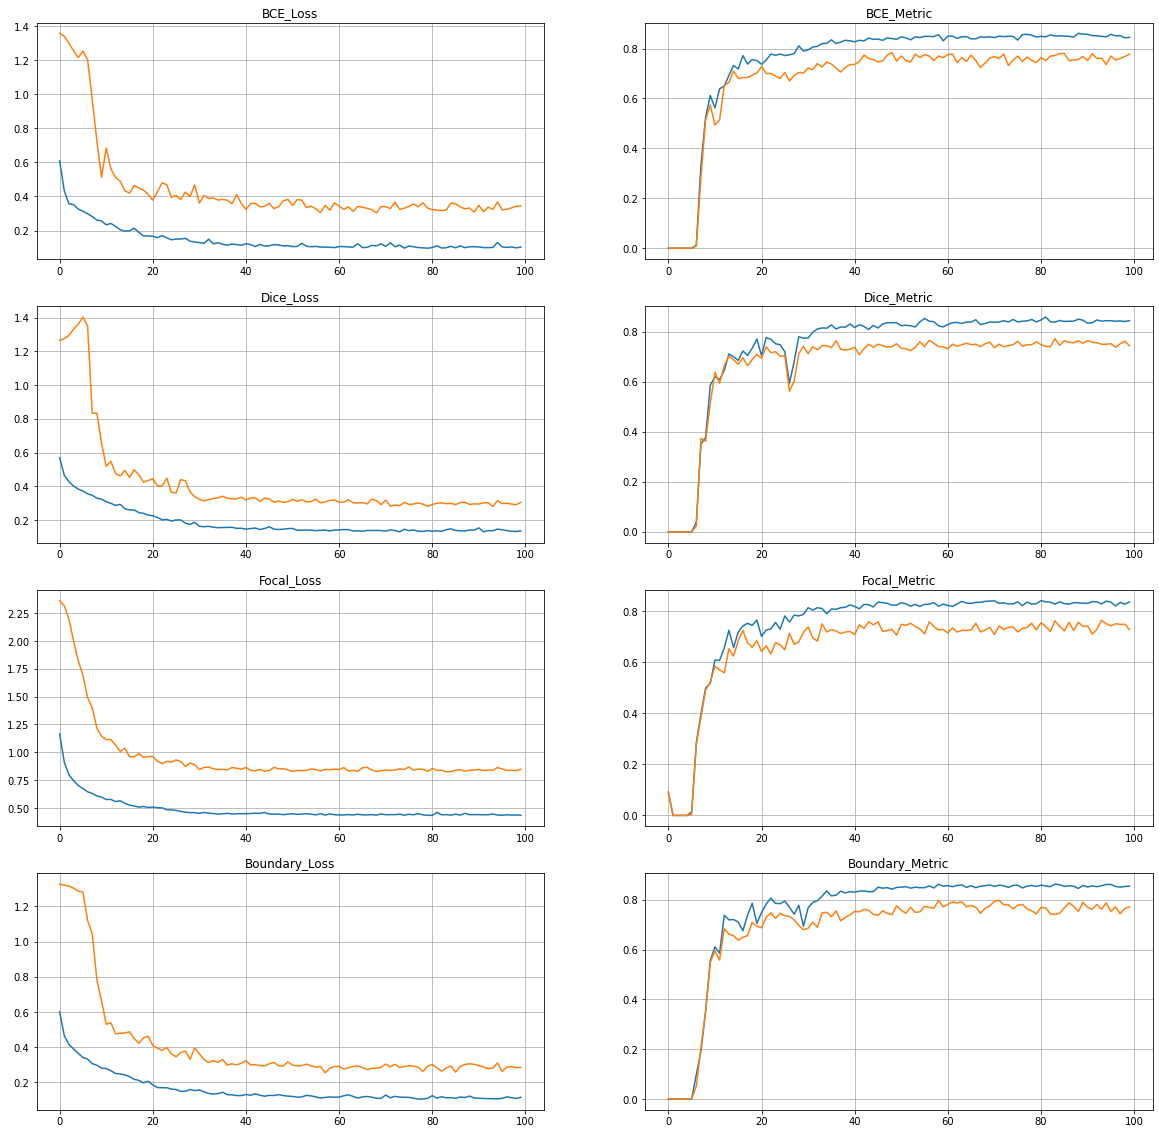

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
ax = ax.ravel()

ax[0].plot(a21_aug)
ax[0].plot(b21_aug)
ax[0].set_title('BCE_Loss')
ax[1].plot(c21_aug)
ax[1].plot(d21_aug)
ax[1].set_title('BCE_Metric')

ax[2].plot(a22_aug)
ax[2].plot(b22_aug)
ax[2].set_title('Dice_Loss')
ax[3].plot(c22_aug)
ax[3].plot(d22_aug)
ax[3].set_title('Dice_Metric')

ax[4].plot(a23_aug)
ax[4].plot(b23_aug)
ax[4].set_title('Focal_Loss')
ax[5].plot(c23_aug)
ax[5].plot(d23_aug)
ax[5].set_title('Focal_Metric')

ax[6].plot(a24_aug)
ax[6].plot(b24_aug)
ax[6].set_title('Boundary_Loss')
ax[7].plot(c24_aug)
ax[7].plot(d24_aug)
ax[7].set_title('Boundary_Metric')

for i in range(8):
    ax[i].grid()

In [ ]:
score_model(unet21_aug,iou_pytorch,val_dataloader), \
score_model(unet22_aug,iou_pytorch,val_dataloader), \
score_model(unet23_aug,iou_pytorch,val_dataloader), \
score_model(unet24_aug,iou_pytorch,val_dataloader)

(0.7720000147819519,
 0.7740000188350677,
 0.7540000081062317,
 0.7639999985694885)

In [ ]:
score_model(unet21_aug,iou_pytorch,data_val), \
score_model(unet22_aug,iou_pytorch,data_val), \
score_model(unet23_aug,iou_pytorch,data_val), \
score_model(unet24_aug,iou_pytorch,data_val)

(0.7580000162124634, 0.757999986410141, 0.7439999878406525, 0.7819999754428864)

# Сравнение моделей

Заметно даже невооруженным глазом, что обучение моделей значительным образом улучшается при использовании аугментации

Теперь, выбрав для каждой модели наилучшую для нее лосс функцию, сравним их между собой. Обучать будем на трейновом датасете, а на тестовом уже будем отмечать разницу моделей

In [ ]:
# Segnet показал примерно одинаковые результаты на всех функциях потерь.
# Различия лишь заключались в гладкости прямых.
# Поэтому возьмем bce_loss, так как на последней итерации с ней метрика достигала наибольшего значения.
model_1_segnet = SegNet().to(device)
opt = optim.Adam(model_1_segnet.parameters(), lr=1e-4)
a,b,c,d = train(model_1_segnet, opt, bce_loss, 100, train_dataloader, data_ts,30)
# Для UNet в качестве оптимальной лосс функции была выбрана Boundary_loss(который в моем случае является generalized dice loss)
# т.к. прямые меньше подвержены девиациям и скачкам + достигается наивысшай скор метрики
model_2_unet1 = UNet().to(device)
opt = optim.Adam(model_2_unet1.parameters(), lr=1e-4)
a1,b1,c1,d1 = train(model_2_unet1, opt, Bloss, 100, train_dataloader, data_ts,30)
# UNet2 наделим в финальной битве Boundary_loss(который в моем случае является generalized dice loss)
# т.к. достигается максимальная метрика и наиболее стабильный рост скора и снижения лосса
model_3_unet2 = UNet2().to(device)
opt = optim.Adam(model_3_unet2.parameters(), lr=1e-4)
a2,b2,c2,d2 = train(model_3_unet2, opt, Bloss, 100, train_dataloader, data_ts,30)

<Figure size 1440x504 with 0 Axes>

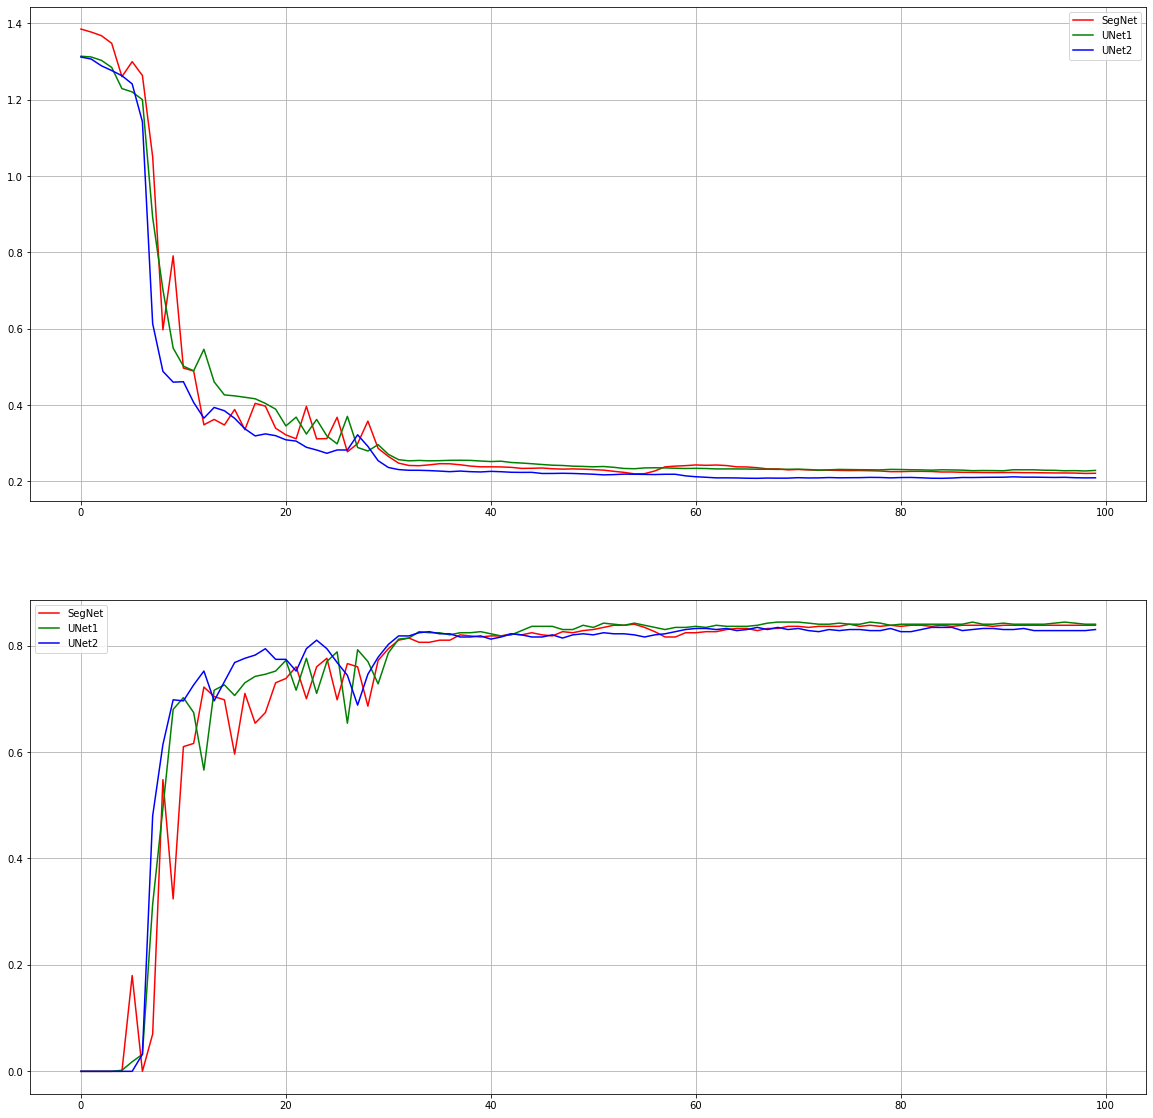

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(20,20))
ax = ax.ravel()

x = np.arange(100)

ax[0].plot(x,b,'r',x,b1,'g',x,b2,'b')
ax[0].grid()
ax[0].legend(['SegNet','UNet1','UNet2'])

ax[1].plot(x,d,'r',x,d1,'g',x,d2,'b')
ax[1].grid()
ax[1].legend(['SegNet','UNet1','UNet2'])

In [ ]:
print('SegNet score: ', score_model(model_1_segnet,iou_pytorch,data_ts))
print('UNet1 score: ', score_model(model_2_unet1,iou_pytorch,data_ts))
print('UNet2 score: ', score_model(model_3_unet2,iou_pytorch,data_ts))

SegNet score:  0.8379999697208405
UNet1 score:  0.8400000035762787
UNet2 score:  0.8299999833106995
